# Iowa Ames House Price Project

# Load the dataset

In [27]:
import pandas as pd
train = pd.read_csv('data/train.csv', index_col=0)
train.head()
pd.options.display.max_rows = 4000

In [28]:
train.shape

(1460, 80)

In [29]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##  Dataset summary:

1. 1460 oberservations, 79 valriables + 1 SalePrice

2. 20 continuous variables relate to various area dimensions for each observation. 

   'LotFrontage','LotArea','MasVnrArea','TotalBsmtSF', 'GrLivArea','PoolArea', 'MiscVal', 'PorchAgg',

3. 14 discrete variables typically quantify the number of items occurring within the house.
   'YearBuilt', 'YearRemodAdd', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageCars', 'MoSold', 'YrSold'

4. 23 nominal categorical variables:
   'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'
    ,'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',' Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Electrical', 'GarageType', 'SaleType']

5. 23 nominal categorical variables:
   'Condition1', 'OverallQual', 'OverallCond', 'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond'
                , 'BsmtFinType1', 'HeatingQC','CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 
                'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence', 'SaleCondition','Baths'


# Data cleaning rational:

1. Alley    93.77% 'NA' : remove
2. LotFrontage with 17.74% missing values:  replace with MEDIAN
3. MasVnrType:  5% missing value : replace with 'No' because MasVnrArea = 0

The following Basement 2.53% missing value is all because of no basement.
4. BsmtQual: 2.53% replace with 'No'.
5. BsmtCond: 2.53% replace with 'No'.
6. BsmtFinType1:  2.53% replace with 'No'.
7. BsmtExposure      2.60% replace with 'No'.

8. Electrical: 1 missing, impute with SBrkr	Standard Circuit Breakers & Romex
9. FireplaceQu: 47.26% missing value, replace with 'No' because of no pool.

The following garage feature with 5.55% missing value, replace with 'No'
10. GarageType 5.55 , 
11. GarageFinish 5.55, 
12. GarageQual  5.55, 
13. GarageCond  5.55,   
14. GarageYrBlt  5.55 ,  Fill with 0.

15. Fence: 80.75% missing value, replace with 'No'
16. MiscFeature 96.30% missing value, replace with 'No' because of MiscVal= 0
17. PoolQC      99.52% missing value, replace with 'No' because of PoolArea = 0


In [30]:
train.isna().mean().round(4)*100

MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
Street            0.00
Alley            93.77
LotShape          0.00
LandContour       0.00
Utilities         0.00
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.00
Exterior2nd       0.00
MasVnrType        0.55
MasVnrArea        0.55
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.53
BsmtCond          2.53
BsmtExposure      2.60
BsmtFinType1      2.53
BsmtFinSF1        0.00
BsmtFinType2      2.60
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.07
1stFlrSF          0.00
2ndFlrSF   

In [31]:
#1 drop Alley column
train = train.drop(columns = ['Alley'])

In [32]:
# data_crosstab = pd.crosstab(train['BsmtQual'], train['BsmtCond'], margins = False)   creating contengency table.
# print(data_crosstab)

In [33]:
#2. LotFrontage: fill missing value with MEAN
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())

In [34]:
#3. MasVnrType:  5% missing value : replace with 'No'
train['MasVnrType'] = train['MasVnrType'].replace('None','No')

In [35]:
#4. BsmtQual: 2.53% replace with 'No'
#5. BsmtCond: 2.53% replace with 'No'
#6. BsmtFinType1:  2.53% replace with 'No'
train['BsmtQual'] = train['BsmtQual'].fillna('No')
train['BsmtCond'] = train['BsmtCond'].fillna('No')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No')
#7. BsmtExposure  2.60% replace with 'No'
train['BsmtExposure'] = train['BsmtExposure'].fillna('No')

In [36]:
#8. Electrical: 1 missing, impute with SBrkr	Standard Circuit Breakers & Romex
train['Electrical'] = train['Electrical'].fillna('SBrkr')

In [37]:
#10. GarageType, 11. GarageFinish, 12. GarageQual, 13. GarageCond replace missing with 'No'
train['GarageType'] = train['GarageType'].fillna('No')
train['GarageFinish'] = train['GarageFinish'].fillna('No')
train['GarageQual'] = train['GarageQual'].fillna('No')
train['GarageCond'] = train['GarageCond'].fillna('No')

#14. GarageYrBlt  5.55 ,  Fill with 0.
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

In [38]:
#15. Fence: 80.75% missing value, replace with 'No'
#16. MiscFeature 96.30% missing value, replace with 'No' because of MiscVal= 0
#17. PoolQC 99.52% missing value, replace with 'No' because of PoolArea = 0
train['Fence'] = train['Fence'].fillna('No')
train['MiscFeature'] = train['MiscFeature'].fillna('No')
train['PoolQC'] = train['PoolQC'].fillna('No')

**Visualize dataset**

In [39]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a5614e0>,
      dtype=object)

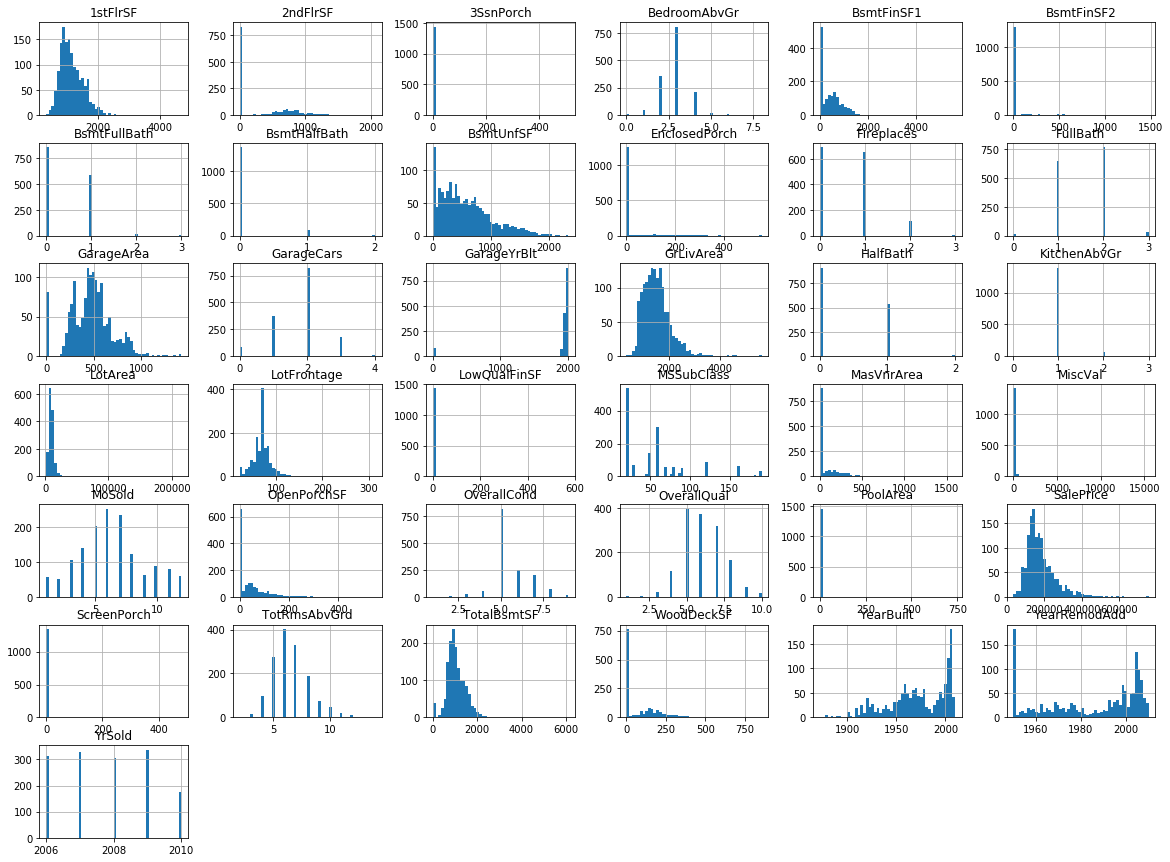

In [40]:
train.hist(bins=50, figsize=(20,15))

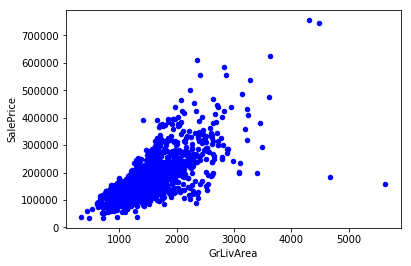

In [41]:
train.plot(kind='scatter', x='GrLivArea', y='SalePrice',c='b')
plt.show()

In [42]:
# remove outliers: GrLivArea above 4000 Square Feet
# train = train[train['GrLivArea'] < 4000]

**Descriptive Statistics**

- Check the descriptive statistics of the numerical columns
- Output the count distribution of each categorical feature

In [43]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Feature Engineering

**Univariate analysis**:
- summarize a continuous variable : use `describe()` function
- summarize a categorical variable we will use `value_counts()` function

**Bivariate analysis and Visualization**:

- Distribution of input/output variables
- Distribution of output in each class of categorical varialbes
- Correlations between continuous variables


**Process**
1. keep: "GrLivArea", remove: "1stFlrSF" , "2ndFlrSF" , "LowQualFinSF"   
   notes: a. "GrLivArea" is the total of the three b. GrLivArea shows strong linear relationship with SalePrice.
2. create a new column:  "Baths" = "FullBath"*4 + "HalfBath"*2 + "BsmtFullBath"*1 + "BsmtHalfBath"*0.5 
3. keep: "TotalBsmtSF", remove:  "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"   

In [44]:
train = train.drop(columns = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

In [45]:
#train['Baths'] = 4*train['FullBath'] + 2*train['HalfBath'] + 1*train['BsmtFullBath'] + 0.5*train['BsmtHalfBath']
#train = train.drop(columns = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])

In [46]:
train = train.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])

4. keep: "BsmtFinType1", remove: "BsmtFinType2"
5. keep: "Condition1", remove "Condition2" 
6. keep: "YearBuilt" & "YearRemod" (Check with Lasso then drop it before Elastic Net or Not
7. remove:  "Heating"

In [47]:
train = train.drop(columns = ['BsmtFinType2', 'Condition2', 'Heating'])

8. remove: Utilities == 'NoSewer' obeservation ( index = 945 ) 
   remove: "Unilities" column
9. keep: "GarageCars", remove "GarageArea" 
10. keep: "GarageQual",  Remove "GarageCond"
11. remove: "GarageYrBlt", only 371 out of 1460 garages were built after the house was built. 
    the difference does not affect much of house price.

In [48]:
train = train[train['Utilities'] != 'NoSeWa']
train = train.drop(columns = ['Utilities', 'GarageArea', 'GarageCond', 'GarageYrBlt'])

12. create a new column: "Porch.Agg" = 1*"EnclosedPorch" + 1*"3SsnPorch" + 0.8*"ScreenPorch" + 0.6*"OpenPorchSF" + 0.5*"WoodDeckSF"
    (Rescale the multipliers later and check the relationship between Porch.Agg and SalePrice)
13. remove:  "PoolQC" due to almost every obs is None
14. remove:  "MiscFeature" but keep the "MiscVal"
15. Should Check MoSold and YearSold to determine whether to integrate or not

In [49]:
train['PorchAgg'] = 1*train['EnclosedPorch'] + 1*train['3SsnPorch'] + 0.8*train['ScreenPorch'] + 0.6*train['OpenPorchSF'] + 0.5*train['WoodDeckSF']
train = train.drop(columns = ['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'])
train = train.drop(columns = ['PoolQC', 'MiscFeature'])


In [50]:
train.shape

(1459, 60)

In [25]:
norminal_catV = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'
                 ,'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',' Exterior2nd', 'MasVnrType', 
                 'Foundation', 'BsmtExposure', 'Electrical', 'GarageType', 'SaleType'] #20
for feature in norminal_catV:
    print(train[feature].value_counts())
    print('')

20     535
60     295
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

RL         1146
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Pave    1449
Grvl       6
Name: Street, dtype: int64

Reg    925
IR1    480
IR2     41
IR3      9
Name: LotShape, dtype: int64

Lvl    1308
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64

Inside     1051
Corner      260
CulDSac      93
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Gtl    1377
Mod      65
Sev      13
Name: LandSlope, dtype: int64

NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
IDOTRR      37
Timber      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
Meadow

KeyError: ' Exterior2nd'

In [26]:
ordinal_catV = ['Condition1', 'OverallQual', 'OverallCond', 'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond'
                , 'BsmtFinType1', 'HeatingQC','CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 
                'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence', 'SaleCondition','Baths'] 

for feature in norminal_catV:
    print(train[feature].value_counts())
    print('')

20     535
60     295
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

RL         1146
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Pave    1449
Grvl       6
Name: Street, dtype: int64

Reg    925
IR1    480
IR2     41
IR3      9
Name: LotShape, dtype: int64

Lvl    1308
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64

Inside     1051
Corner      260
CulDSac      93
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Gtl    1377
Mod      65
Sev      13
Name: LandSlope, dtype: int64

NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
IDOTRR      37
Timber      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
Meadow

KeyError: ' Exterior2nd'

In [187]:
y = pd.Series(train['SalePrice'])

In [201]:
train.columns.to_list()

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'PavedDrive',
 'PoolArea',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice',
 'Baths',
 'PorchAgg']

In [28]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
data = train[numeric_V]
print(pt.fit(data))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

print(pt.lambdas_)
print(pt.transform(data))

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[ 5.32105515e-01 -8.31423913e+00 -2.41775562e-01  2.30452035e-01
 -1.51730929e+00  4.70652125e-01  8.07244934e-01  5.04162962e-03
 -1.30293352e-01 -9.99118856e+00 -9.99118856e+00  1.17307775e-01
  8.17841627e-01 -8.16254707e-02  1.01418816e-02 -1.41586895e+00
 -1.16395586e+01 -2.42818426e+00 -4.55959249e+01 -4.27172802e+00]
[[-0.16612896  0.          1.22880311 ... -0.29422298 -0.05870178
  -0.19245009]
 [ 0.55009913  0.         -0.82057326 ... -0.29422298 -0.05870178
  -0.19245009]
 [-0.01723035  0.          1.19167484 ... -0.29422298 -0.05870178
  -0.19245009]
 ...
 [-0.11615076  0.         -0.82057326 ... -0.29422298 -0.05870178
   5.19615243]
 [-0.01723035  0.         -0.82057326 ... -0.29422298 -0.05870178
  -0.19245009]
 [ 0.31884612  0.         -0.82057326 ... -0.29422298 -0.05870178
  -0.19245009]]


/Users/lanmond/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


**Before going further, the following data preprocessing steps will be applicable to all models:**

Create dummy variables from the feature “purpose” since its nominal (not ordinal) categorical variable. It’s also a good practice to drop the first one to avoid linear dependency between the resulted features since some algorithms may struggle with this issue.
Split the data into training set (70%), and test set (30%). Training set will be used to fit the model, and test set will be to evaluate the best model to get an estimation of generalization error. Instead of having validation set to tune hyperparameters and evaluate different models, we’ll use 10-folds cross validation because it’s more reliable estimate of generalization error.
Standardize the data. We’ll be using RobustScaler so that the standarization will be less influenced by the outliers, i.e. more robust. It centers the data around the median and scale it using interquartile range (IQR). This step will be included in the pipelines for each model as a transformer so we will not do it separately.

In [25]:
norminal_catV = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope'
                 ,'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',' Exterior2nd', 
                 'MasVnrType', 'Foundation', 'BsmtExposure', 'Electrical', 'GarageType', 'SaleType'] #20

ordinal_catV = ['Condition1', 'OverallQual', 'OverallCond', 'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond'
                , 'BsmtFinType1', 'HeatingQC','CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 
                'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence', 'SaleCondition','Baths'] #19

discrete_V = ['YearBuilt', 'YearRemodAdd', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageCars', 
              'MoSold', 'YrSold', "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"] # 13

numeric_V = ['LotFrontage','LotArea','MasVnrArea','TotalBsmtSF', 'GrLivArea','PoolArea', 'MiscVal', 'PorchAgg'] # 8 Variables



In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

In [27]:
Pipeline1 = make_pipeline(OneHotEncoder())
Pipeline2 = make_pipeline(OrdinalEncoder())
#Pipeline4 = make_pipeline(StandardScaler())

Pipeline_scale = make_pipeline( RobustScaler() )

transformer = ColumnTransformer([
    ("nominal", Pipeline1 , nominal_catV),
    ("discrete", pipeline1, discrete_V),
    ("ordinal", Pipeline2, ordinal_catV),
    ("scale", Pipeline_scale, numeric_V)])

sp.csr_matrix((data, indices, indptr), shape=(3, 3))

x = transformer.fit_transform(train_data).to_dense()
x = np.array(x)
pd.DataFrame(x)

NameError: name 'make_pipeline' is not defined

Based on the above graph, the data with GrLivArea should be removed as outliers.

In [29]:
indexes = ['MSSubClass',
 'LotFrontage',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'SalePrice']
ames_simple = ames[indexes]
ames_simple.head()

,MSSubClass,LotFrontage,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,SalePrice
Id,,,,,,,,,,,
1,60,65.0,1710,2,1,3,1,8,0,2,208500
2,20,80.0,1262,2,0,3,1,6,1,2,181500
3,60,68.0,1786,2,1,3,1,6,1,2,223500
4,70,60.0,1717,1,0,3,1,7,1,3,140000
5,60,84.0,2198,2,1,4,1,9,1,3,250000


In [30]:
from sklearn import linear_model
ols = linear_model.LinearRegression()

In [31]:
X = ames_simple[['MSSubClass',
 'LotFrontage',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'SalePrice']]

y = ames_simple[['SalePrice']]

In [37]:
ols.fit(X, y)
print("Intercept beta_0: %f" %ols.intercept_)
print("Coefficients: %s" %str(ols.coef_))

print("RSS: %.2f" % np.sum((ols.predict(X) - y) ** 2))
print("R^2: %.5f" % ols.score(X, y))



Intercept beta_0: -0.000000
Coefficients: [[-1.59035628e-13 -1.17262763e-12 -8.61468963e-15 -8.76764551e-12
   5.48335837e-12  1.18091684e-11  7.20590281e-11 -8.76524535e-12
   2.81944495e-13 -3.28172213e-11  1.00000000e+00]]
RSS: 0.00
R^2: 1.00000


- Fit a multiple linear regression model with the 11 predictors.

- estimated coefficients.

- the overall R^2



<p><a name="case"></a></p>
## Case Study

<p><a name="descriptive"></a></p>
### Descriptive Statistics

In addition to the assumptions we have for the simple linear regression, multiple linear regression also makes a key assumption:

- Low multicollinearity among the predictors

But in reality the real world data is very unlikely to satisfy this assumption. Failing to satisfy the assumption may lead to poor model fit or even wrong result.

Below we will explore some basic descriptive statistics to understand the variables before fitting the linear model.

- Univariate analysis: involve the distribution of a single variable (mean, median, quartiles, standard deviation, etc.)
- Bivariate analysis: explore the pairwise relationship between different variables (correlation, covariance, etc.)

<p><a name="ex3"></a></p>
### Exercise: Descriptive Statistics

- The 1970s' Boston House Prices dataset includes 506 instances with 11 continuous variables, 1 categorical variable (RAD) and 1 binary-valued variable (CHAS)

- RAD: index of accessibility to radial highways

- CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)

- AGE - proportion of owner-occupied units built prior to 1940

- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

- CRIM - per capita crime rate by town

- DIS - weighted distances to five Boston employment centres

- INDUS - proportion of non-retail business acres per town

- LSTAT - % lower status of the population

- MEDV - Median value of owner-occupied homes in $1000's

- NOX - nitric oxides concentration (parts per 10 million)

- PTRATIO - pupil-teacher ratio by town

- RM - average number of rooms per dwelling

- TAX - full-value property-tax rate per $10,000

- ZN - proportion of residential land zoned for lots over 25,000 sq.ft

- The dataset is available in scikit datasets sub-package

<p><a name="dummy"></a></p>
### Categorical Input Variables

So far all the input variables we’ve seen are continuous variables.
It’s possible that we will have categorical (aka, qualitative) input variables. 

- For example, if we want to explore the relationship between smoking and lung cancer rate, the variable 'smoking' usually has two categories, “yes” and “no”.

- The binary categorical variables can be effectively coded as integers. For instance [“yes”, “no”] are often coded as [1, 0].

- When there are more than two categories, we cannot simply code the variables by more integers,  as scikit-learn estimators expects continuous input, and would interpret the categories as being ordered, which is often not desired. 

The most useful and commonly used coding is via introducing dummy variables: a $K$-level categorical variable is represented by K binary variables, only one of which is on at a time. This is called 1-of-K encoding scheme.

- Scikit-learn provides a class called OneHotEncoder which encodes categorical variables using 1-of-K scheme, but it only accepts integer-value features as input.

- We will be using `pandas.get_dummies()` function to convert categorical variables. This works fine if the data size is not big

Example - Assuming a laptop sales data set has a feature called web browser which records the types of pre-installed web browser for 5 different laptop models.


In [19]:
import pandas as pd
browser = pd.Series(["Safari","Chrome", "IE", "IE", "Safari"])
browser_dummy = pd.get_dummies(browser)
browser_dummy

,Chrome,IE,Safari
0,0,0,1
1,1,0,0
2,0,1,0
3,0,1,0
4,0,0,1


- In the previous example we generate 3 dummy variables, as the number of categories is 3. For each single record we only have one “1” and the rest are all 0’s.

- We can consider one category as the base and drop it without losing any information since these dummified features are linearly dependent (summing to one).

- So the following dummy variables will be sufficient.

In [20]:
browser_dummy.drop('Chrome', 1)

,IE,Safari
0,0,1
1,0,0
2,1,0
3,1,0
4,0,1


<p><a name="ex4"></a></p>
#### Exercise: Dummy Variables

To apply multiple linear regression, you’ll need to transform the categorical variable RAD to dummy variables. CHAS is binary and therefore we don’t need to convert it to dummy variables.

- Dummify the RAD column and put it back with the other features.

In [21]:
df = X_bos.copy()
#### Isolate the RAD column and dummify it into a data frame with columns RAD__1.0,...., RAD__24.0
#### drop the RAD__1.0 column before concatenating with df (the original RAD has to be dropped, too)
#### use head to print the top 5 lines, as is shown below
#### Your code here
#pd.get_dummies?
rad = pd.get_dummies(df['RAD'], prefix='RAD', prefix_sep='__')
rad = rad.drop('RAD__1.0', axis=1)
rad.head()
df = pd.concat([df.drop('RAD', axis=1), rad], axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,RAD__2.0,RAD__3.0,RAD__4.0,RAD__5.0,RAD__6.0,RAD__7.0,RAD__8.0,RAD__24.0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,296.0,15.3,396.90,4.98,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,242.0,17.8,396.90,9.14,1,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,242.0,17.8,392.83,4.03,1,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,222.0,18.7,394.63,2.94,0,1,0,0,0,0,0,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,222.0,18.7,396.90,5.33,0,1,0,0,0,0,0,0


In [22]:
pd.DataFrame(df.columns, columns=['Column_Name'])

,Column_Name
0,CRIM
1,ZN
2,INDUS
3,CHAS
4,NOX
5,RM
6,AGE
7,DIS
8,TAX
9,PTRATIO


Below we split the data into **train** set and the **test** set. Then we will train our models on the train set and evaluate it with the test set. This is a standard process for model evaluation, which we will discuss with more details in a separate session.

In [23]:
try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y_bos, test_size=0.3, random_state=42)

- Do **multiple linear regression** with a new data set.
- Report the coefficient of determination from the training and testing sets.

In [24]:
#### Your code here
from sklearn.linear_model import LinearRegression 

ols = LinearRegression()
ols.fit(X_train, y_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print('-'*50)

print("R^2 for test  set: %f" %ols.score(X_test, y_test))

R^2 for train set: 0.754141
--------------------------------------------------
R^2 for test  set: 0.714336


# OverFit
- The discrepency of $R^2$ between the train and test sets is usually called **over-fitting**

## Detecting Multicollinearity Among Features
- We can detect multicollinearity by running a separate **MLR** using each continuous feature as a target
- The $R^2$ score of each **MLR** gauges whether each feature is linear dependent on the others

In [25]:
continuous_features = ['CRIM', 'INDUS', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scores = {}
ols2 = LinearRegression()
from sklearn.metrics import r2_score
for feature_name in continuous_features:
                df2     = df.copy()
                feature = df2[feature_name].copy()
                df2.drop(feature_name, axis=1, inplace=True)
                ols2.fit(df2, feature)
                scores[feature_name] = ols2.score(df2, feature)   

Text(0.5,1,'$R^2$ of a continuous feature against the other features')

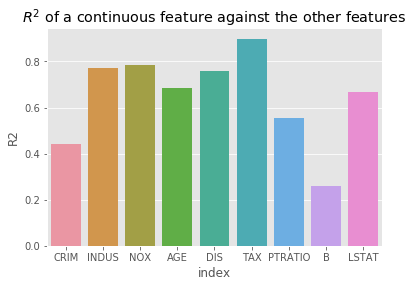

In [26]:
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')

## High Multicollinearity Is the Main Reason of Multi-Variable Linear Model Overfitting
- Because multicollinearity, the model coefficients estimated by the LinearRegression model can be very far away from 
where the true model should lie (assuming that the linearity and i.i.d Gaussian assumptions are not violated)

Below we list the coefficients for each variable.

In [27]:
colnames = df.columns
result = pd.DataFrame(ols.coef_).transpose()
result.columns = colnames.tolist()
result['intercept'] = ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result

,coefficient
CRIM,-0.134596
ZN,0.043598
INDUS,0.064662
CHAS,2.923517
NOX,-16.260766
RM,3.947485
AGE,-0.011712
DIS,-1.464337
TAX,-0.005080
PTRATIO,-0.902115


## The Meaning of Dummified Slopes
- Because a dummified feature takes boolean values (0 or 1), the slope of a binary feature has a very simple meaning
- The subset of samples which take feature value 1 forms a subgroup
- Different subgroups form a partition of the data set
- In the above examples, houses have RAD scores 1, 2, 3, 4, 5, 6, 7, 8, 24 and we can partition the houses into different subgroups
in this way
- The slope of RAD_24.0 adjusts the intercept 30.1518 upwards to 35.9627
- In other words, after dummification, each subgroup fits a linear model with an individual intercept, but the linear model
of all the subgroups share the identical slopes on the non-dummified continuous variables 

In [28]:
result.index

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'RAD__2.0', 'RAD__3.0', 'RAD__4.0', 'RAD__5.0',
       'RAD__6.0', 'RAD__7.0', 'RAD__8.0', 'RAD__24.0', 'intercept'],
      dtype='object')

In [29]:
slopes = result.loc[['CRIM','ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
slopes.columns = ['slope']
slopes

,slope
CRIM,-0.134596
ZN,0.043598
INDUS,0.064662
NOX,-16.260766
RM,3.947485
AGE,-0.011712
DIS,-1.464337
TAX,-0.005080
PTRATIO,-0.902115
B,0.012152


## Summary on the Slopes
- Crime rate, AGE, NOX, local tax rate, student/teacher ratio, low income residents ratio impact house price negatively
- Zoning, INDUS (non-retail business acres), black resident index impact house price positively

## Depending on whether CHAS == 1 and the RAD index, the data set can be sub-divided into 18 subgroups
- We would like to know the intercept term fitted to each sub-population of the data

In [30]:
# the sample count in each sub-population
relevant = ['CHAS', 'RAD']
X_bos[relevant+['ZN']].groupby(relevant).count()

ZN
CHAS RAD      
0.0  1.0    19
     2.0    24
     3.0    36
     4.0   102
     5.0   104
     6.0    26
     7.0    17
     8.0    19
     24.0  124
1.0  1.0     1
     3.0     2
     4.0     8
     5.0    11
     8.0     5
     24.0    8

- We notice that the CHAS == 1 house population is rather sparse, most of the counts are single digits
- CHAS == 1 and RAD == 2, 6, 7 are missing 
- The following code computes the per-group intercepts in a multi-index data frame

In [31]:
intercept = result.loc[['RAD__2.0', 'RAD__3.0', 'RAD__4.0', 'RAD__5.0', 'RAD__6.0', 'RAD__7.0', 'RAD__8.0', 'RAD__24.0']]
intercept.loc['RAD__1.0'] = 0.0
intercept = intercept + result.loc['intercept']
intercept = intercept.reset_index()
intercept2 = intercept.copy() 
intercept2['coefficient'] += float(result.loc['CHAS'])
intercept = pd.concat([intercept, intercept2], axis=0)
intercept['CHAS'] = [0]*9 + [1]*9

In [32]:
intercept = intercept.groupby(['CHAS','index']).mean()
intercept.columns = ['intercept']
intercept

intercept
CHAS index               
0    RAD__1.0   30.151808
     RAD__2.0   31.282496
     RAD__24.0  35.962705
     RAD__3.0   34.657038
     RAD__4.0   32.042686
     RAD__5.0   32.920022
     RAD__6.0   30.604760
     RAD__7.0   34.435277
     RAD__8.0   34.115608
1    RAD__1.0   33.075325
     RAD__2.0   34.206013
     RAD__24.0  38.886222
     RAD__3.0   37.580555
     RAD__4.0   34.966204
     RAD__5.0   35.843539
     RAD__6.0   33.528277
     RAD__7.0   37.358794
     RAD__8.0   37.039125

## What are the Significance of the Slope Coefficients?
- As scikit-learn does not output t-stats or confidence intervals, we need to use statsmodels for this task 

In [33]:
import statsmodels.api as sm 
X_add_const = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     51.07
Date:                Mon, 01 Oct 2018   Prob (F-statistic):           1.00e-88
Time:                        12:07:13   Log-Likelihood:                -1046.3
No. Observations:                 354   AIC:                             2135.
Df Residuals:                     333   BIC:                             2216.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.1518      6.558      4.598      0.0

In [34]:
ans.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,30.1518,6.558,4.598,0.000,17.251,43.052
CRIM,-0.1346,0.040,-3.329,0.001,-0.214,-0.055
ZN,0.0436,0.018,2.425,0.016,0.008,0.079
INDUS,0.0647,0.075,0.859,0.391,-0.083,0.213
CHAS,2.9235,1.038,2.816,0.005,0.881,4.966
NOX,-16.2608,4.891,-3.324,0.001,-25.883,-6.639
RM,3.9475,0.501,7.885,0.000,2.963,4.932
AGE,-0.0117,0.016,-0.717,0.474,-0.044,0.020
DIS,-1.4643,0.245,-5.976,0.000,-1.946,-0.982
TAX,-0.0051,0.005,-1.066,0.287,-0.014,0.004


In [35]:
table = pd.DataFrame(ans.summary().tables[1].data[1:])
table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float,'2.5% confidence':float, '97.5% confidence':float})
table[table['p value']<0.05]  # those coefficients with 0 lying outside their CIs

,name,coef,std err,t value,p value,2.5% confidence,97.5% confidence
0,const,30.1518,6.558,4.598,0.000,17.251,43.052
1,CRIM,-0.1346,0.040,-3.329,0.001,-0.214,-0.055
2,ZN,0.0436,0.018,2.425,0.016,0.008,0.079
4,CHAS,2.9235,1.038,2.816,0.005,0.881,4.966
5,NOX,-16.2608,4.891,-3.324,0.001,-25.883,-6.639
6,RM,3.9475,0.501,7.885,0.000,2.963,4.932
8,DIS,-1.4643,0.245,-5.976,0.000,-1.946,-0.982
10,PTRATIO,-0.9021,0.172,-5.239,0.000,-1.241,-0.563
11,B,0.0122,0.003,3.675,0.000,0.006,0.019
12,LSTAT,-0.5482,0.059,-9.257,0.000,-0.665,-0.432


In [36]:
table[table['p value']>=0.05] # those coefficients with 0 lying in their CIs

,name,coef,std err,t value,p value,2.5% confidence,97.5% confidence
3,INDUS,0.0647,0.075,0.859,0.391,-0.083,0.213
7,AGE,-0.0117,0.016,-0.717,0.474,-0.044,0.020
9,TAX,-0.0051,0.005,-1.066,0.287,-0.014,0.004
13,RAD__2.0,1.1307,1.731,0.653,0.514,-2.274,4.535
15,RAD__4.0,1.8909,1.440,1.313,0.190,-0.943,4.724
16,RAD__5.0,2.7682,1.471,1.882,0.061,-0.125,5.662
17,RAD__6.0,0.4530,1.742,0.260,0.795,-2.974,3.880


## Normalization of the Features
- All features are of different scale, this makes comparing the strengths of coefficients difficult
- In scikit-learn, there are ways to scale the features

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 

In [38]:
scaleType = 'standard'
if scaleType not in ['standard', 'minmax', 'maxabs']: 
           raise ValueError('%s is not a valid choice' %(scaleType))
if scaleType == 'standard':
      scaler = StandardScaler()
elif scaleType == 'minmax':
      scaler = MinMaxScaler()
elif scaleType == 'maxabs':
      scaler = MaxAbsScaler()

# Fix the scale model using the train set
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [39]:
X_add_const = sm.add_constant(X_train_scaled)
ols = sm.OLS(y_train, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     51.07
Date:                Mon, 01 Oct 2018   Prob (F-statistic):           1.00e-88
Time:                        12:07:14   Log-Likelihood:                -1046.3
No. Observations:                 354   AIC:                             2135.
Df Residuals:                     333   BIC:                             2216.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0158      0.255     90.348      0.0

In [40]:
plt.rcParams['figure.figsize'] = (10,5)
y_min, y_max = -6.0,5.0

table = pd.DataFrame(ans.summary().tables[1].data[1:])
table.columns = ['name','coef','std err','t value','p value','2.5% confidence','97.5% confidence']
table = table.astype({'name':str,'coef':float,'std err':float, 't value':float, 'p value':float, '2.5% confidence':float, '97.5% confidence':float})
slope_table = table[['name', 'coef', '2.5% confidence', '97.5% confidence']].iloc[1:]
slope_table.name = df.columns

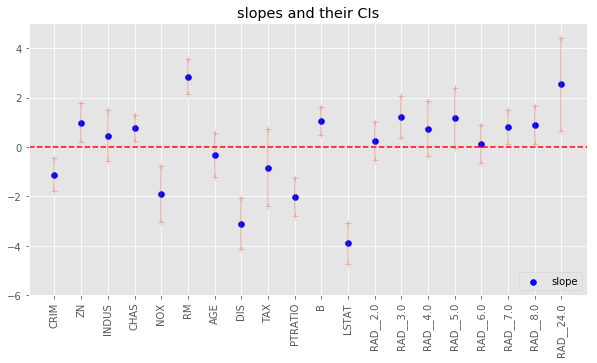

In [41]:
slope_table['y_min'] = slope_table['2.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
slope_table['y_max'] = slope_table['97.5% confidence'].map(lambda t:(t-y_min)/(y_max-y_min))
x = range(1,21)
plt.scatter(x, slope_table['coef'], label='slope', c='b')
plt.axhline(0,linestyle='--', c='r')

for i in x:
    plt.axvline(i, ymin=slope_table['y_min'][i], ymax=slope_table['y_max'][i], marker='+', alpha=0.3)
plt.xticks(x,slope_table.name,rotation='vertical')
plt.ylim((y_min, y_max))
plt.title('slopes and their CIs')
plt.legend(loc=4)